In [7]:
from google.colab import files
uploaded = files.upload()


Saving bank-additional-full.csv to bank-additional-full.csv


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Balancing
from imblearn.over_sampling import SMOTE

# Explainability
import shap
import joblib


In [9]:
df = pd.read_csv('bank-additional-full.csv', sep=';')
df.shape
df.head()


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


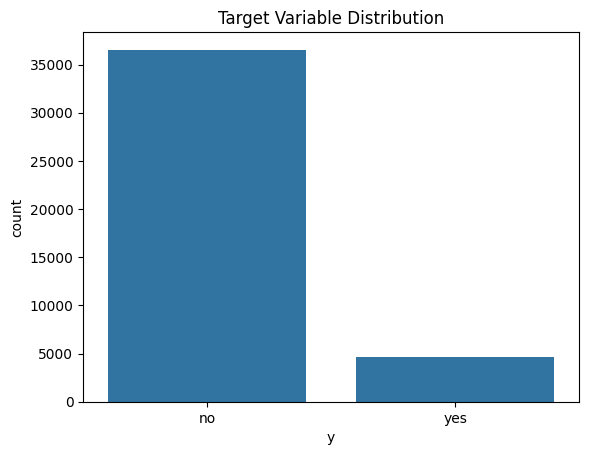

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
count,41188.00000,41188,41188,41188,41188,41188,41188,41188,41188,41188,...,41188.000000,41188.000000,41188.000000,41188,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188
unique,NaN,12,4,8,3,3,3,2,10,5,...,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,2
top,NaN,admin.,married,university.degree,no,yes,no,cellular,may,thu,...,NaN,NaN,NaN,nonexistent,NaN,NaN,NaN,NaN,NaN,no
freq,NaN,10422,24928,12168,32588,21576,33950,26144,13769,8623,...,NaN,NaN,NaN,35563,NaN,NaN,NaN,NaN,NaN,36548
mean,40.02406,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.567593,962.475454,0.172963,NaN,0.081886,93.575664,-40.502600,3.621291,5167.035911,NaN
std,10.42125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.770014,186.910907,0.494901,NaN,1.570960,0.578840,4.628198,1.734447,72.251528,NaN
min,17.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,0.000000,0.000000,NaN,-3.400000,92.201000,-50.800000,0.634000,4963.600000,NaN
25%,32.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,999.000000,0.000000,NaN,-1.800000,93.075000,-42.700000,1.344000,5099.100000,NaN
50%,38.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.000000,999.000000,0.000000,NaN,1.100000,93.749000,-41.800000,4.857000,5191.000000,NaN
75%,47.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.000000,999.000000,0.000000,NaN,1.400000,93.994000,-36.400000,4.961000,5228.100000,NaN


In [10]:
# Target distribution
sns.countplot(x='y', data=df)
plt.title("Target Variable Distribution")
plt.show()

# Summary statistics
df.describe(include='all')


In [11]:
for col in df.columns:
    if df[col].dtype == 'object':
        print(f"{col}: {df[col].value_counts().get('unknown', 0)} unknowns")

# Remove rows with any 'unknown' values
df = df[~df.isin(['unknown']).any(axis=1)]


job: 330 unknowns
marital: 80 unknowns
education: 1731 unknowns
default: 8597 unknowns
housing: 990 unknowns
loan: 990 unknowns
contact: 0 unknowns
month: 0 unknowns
day_of_week: 0 unknowns
poutcome: 0 unknowns
y: 0 unknowns


In [12]:
df['y'] = df['y'].map({'no': 0, 'yes': 1})


In [13]:
df_encoded = pd.get_dummies(df, drop_first=True)


In [14]:
cleaned_df = df_encoded.copy()
cleaned_df.to_csv("bank_cleaned.csv", index=False)

from google.colab import files
files.download("bank_cleaned.csv")  # Download cleaned CSV


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
X = cleaned_df.drop('y', axis=1)
y = cleaned_df['y']


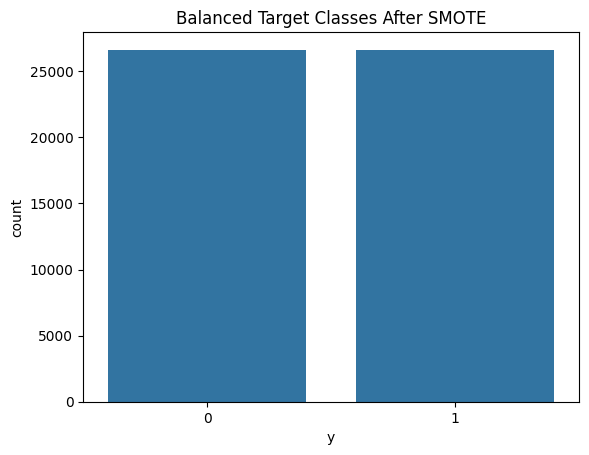

In [16]:
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X, y)

# Check new class distribution
sns.countplot(x=y_resampled)
plt.title("Balanced Target Classes After SMOTE")
plt.show()


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)


In [18]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [19]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)


RandomForestClassifier()

In [20]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [21]:
def evaluate_model(model, name):
    y_pred = model.predict(X_test)
    print(f"--- {name} ---")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

evaluate_model(lr, "Logistic Regression")
evaluate_model(rf, "Random Forest")
evaluate_model(xgb_model, "XGBoost")


--- Logistic Regression ---
Accuracy: 0.9257729377894605
Precision: 0.9330204236965622
Recall: 0.9178834394109572
F1 Score: 0.9253900352289884

Confusion Matrix:
 [[7437  528]
 [ 658 7355]]

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.93      0.93      7965
           1       0.93      0.92      0.93      8013

    accuracy                           0.93     15978
   macro avg       0.93      0.93      0.93     15978
weighted avg       0.93      0.93      0.93     15978

--- Random Forest ---
Accuracy: 0.949805983226937
Precision: 0.9430994223915448
Recall: 0.9576937476600524
F1 Score: 0.9503405572755418

Confusion Matrix:
 [[7502  463]
 [ 339 7674]]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.94      0.95      7965
           1       0.94      0.96      0.95      8013

    accuracy                           0.95     15978
   macro avg       0.95      0.9

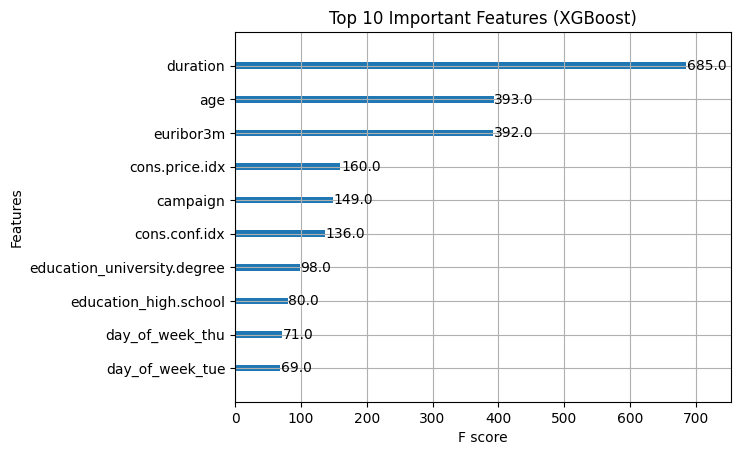

In [22]:
xgb.plot_importance(xgb_model, max_num_features=10)
plt.title("Top 10 Important Features (XGBoost)")
plt.show()


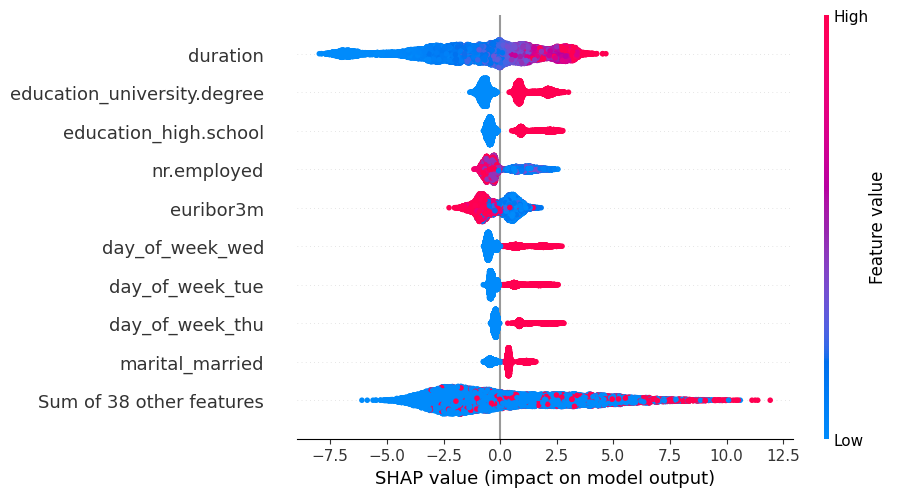

In [23]:
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test)

# SHAP Beeswarm Plot (Global feature impact)
shap.plots.beeswarm(shap_values)


In [24]:
joblib.dump(xgb_model, 'xgb_term_deposit_model.pkl')
files.download('xgb_term_deposit_model.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [25]:
# Create a function to compute all metrics
def get_metrics(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred)
    }

# Compute metrics for all models
metrics = {
    "Logistic Regression": get_metrics(lr, X_test, y_test),
    "Random Forest": get_metrics(rf, X_test, y_test),
    "XGBoost": get_metrics(xgb_model, X_test, y_test)
}

# Convert to DataFrame
metrics_df = pd.DataFrame(metrics).T
metrics_df = metrics_df.round(3)  # Round for cleaner display

# Display the DataFrame
print("Model Performance Summary:")
display(metrics_df)


Model Performance Summary:


,Accuracy,Precision,Recall,F1 Score
Logistic Regression,0.926,0.933,0.918,0.925
Random Forest,0.950,0.943,0.958,0.950
XGBoost,0.946,0.946,0.946,0.946


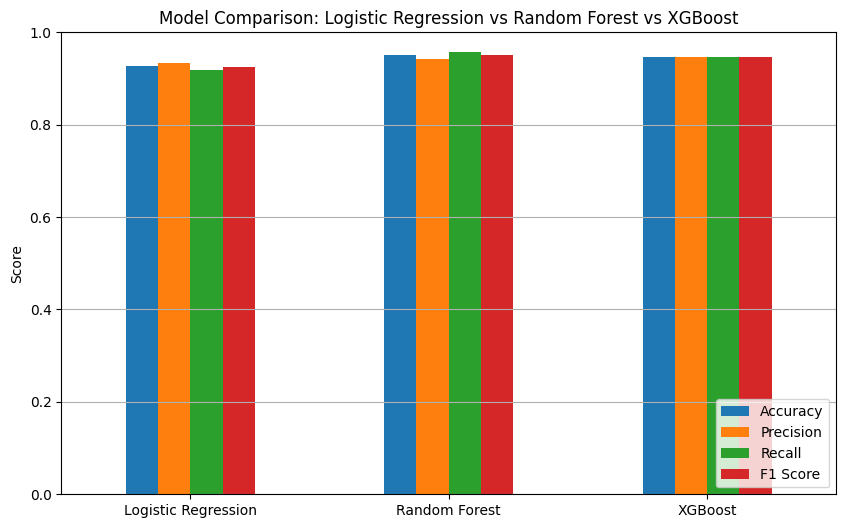

In [26]:
# Plot a bar chart for each metric
metrics_df.plot(kind='bar', figsize=(10, 6))
plt.title('Model Comparison: Logistic Regression vs Random Forest vs XGBoost')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.grid(axis='y')
plt.show()


In [27]:
# Get predicted probabilities
probs = xgb_model.predict_proba(X_test)[:, 1]

# Add to DataFrame
results_df = X_test.copy()
results_df['subscription_probability'] = probs
results_df['actual'] = y_test.values

# View top 10 customers most likely to subscribe
results_df.sort_values(by='subscription_probability', ascending=False).head(10)


,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success,subscription_probability,actual
53092,48,766,2,999,0,1.400000,93.643956,-38.884191,4.963578,5228.100000,...,False,False,False,True,False,True,True,False,1.0,1
32803,30,516,1,999,0,-1.800000,92.860654,-48.658321,1.435615,5099.100000,...,False,False,True,False,False,True,True,False,1.0,1
51161,34,442,2,7,1,-3.251674,92.517956,-27.632358,0.727306,5016.684208,...,True,False,False,False,True,True,False,True,1.0,1
40112,26,550,1,999,0,-1.800000,93.021122,-46.833572,1.387502,5099.100000,...,False,False,False,True,False,True,True,False,1.0,1
49031,35,1264,2,999,0,1.400000,94.144683,-42.327030,4.960829,5228.100000,...,False,False,True,False,False,True,True,False,1.0,1
43373,47,100,1,999,0,-1.800000,93.072367,-47.086978,1.403047,5099.100000,...,False,False,False,False,True,True,True,False,1.0,1
52962,49,767,1,999,0,1.400000,93.692869,-39.565266,4.963475,5228.100000,...,False,False,False,True,False,True,True,False,1.0,1
46527,36,569,2,999,0,-3.400000,92.404229,-28.393006,0.761108,5017.500000,...,True,True,False,True,False,True,True,False,1.0,1
34819,47,100,1,999,0,-1.800000,93.072372,-47.087002,1.403050,5099.100000,...,False,False,False,False,True,True,True,False,1.0,1
33450,36,569,2,999,0,-3.400000,92.386960,-29.356078,0.774724,5017.500000,...,True,True,False,True,False,True,True,False,1.0,1


In [28]:
high_prob = results_df[results_df['subscription_probability'] > 0.7]
conversion_rate = high_prob['actual'].mean()

print(f"If you call only high-probability customers (>70%), expected conversion rate = {conversion_rate:.2f}")
print(f"Total calls reduced to: {len(high_prob)} from {len(results_df)}")


If you call only high-probability customers (>70%), expected conversion rate = 0.97
Total calls reduced to: 7437 from 15978


In [29]:
X_test_copy = X_test.copy()
X_test_copy['subscription_probability'] = xgb_model.predict_proba(X_test)[:, 1]
X_test_copy['actual'] = y_test.values
X_test_copy.reset_index(drop=True, inplace=True)
X_test_copy.to_csv("bank_predictions.csv", index=False)

from google.colab import files
files.download("bank_predictions.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>